In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

In [3]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [4]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [5]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')
tr_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [6]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')
ts_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


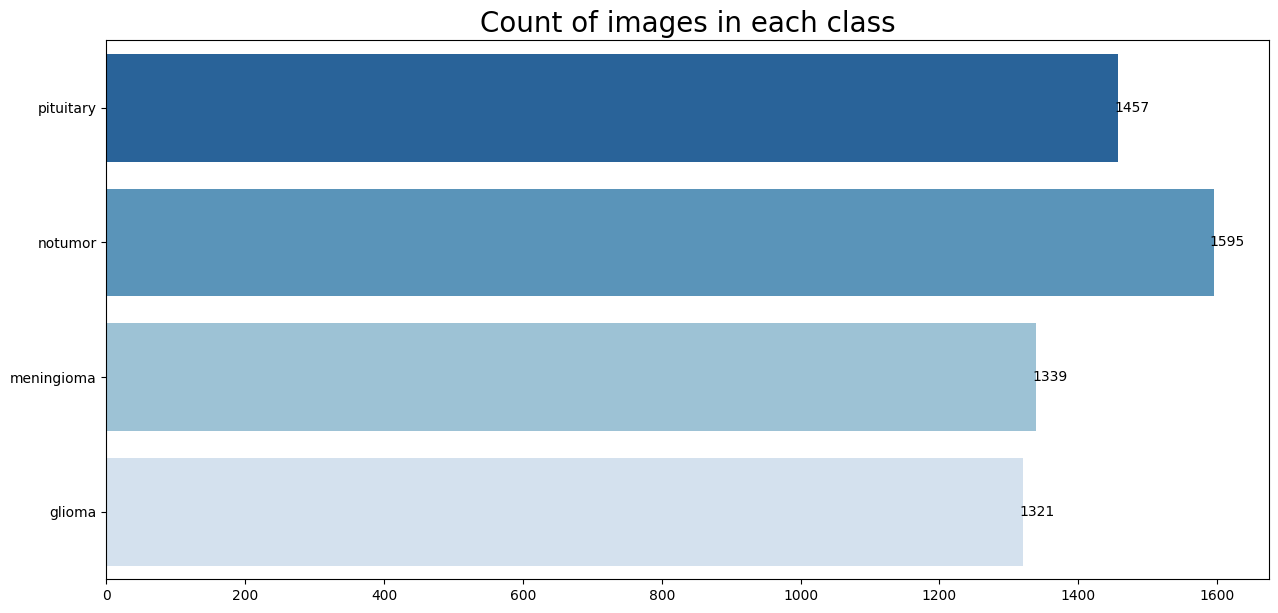

In [7]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=tr_df, y=tr_df['Class'], palette='Blues_r')  

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha = 'center', va = 'center', 
                xytext = (10, 0), 
                textcoords = 'offset points')

plt.show()

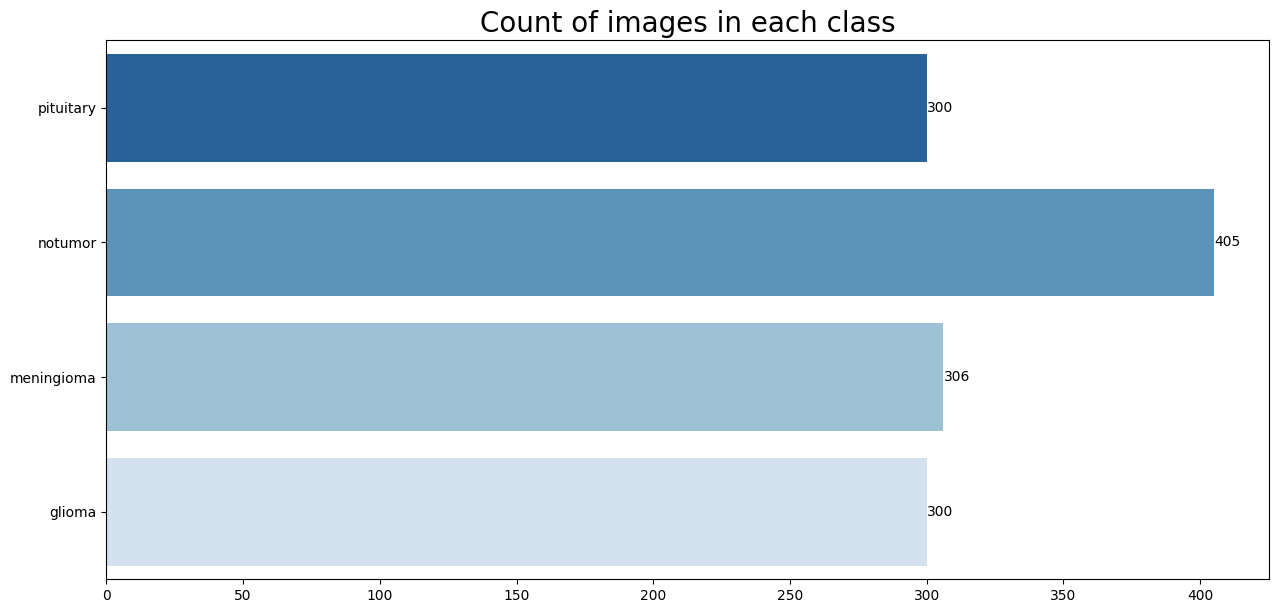

In [8]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=ts_df, y=ts_df['Class'], palette='Blues_r') 

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha = 'center', va = 'center', 
                xytext = (10, 0), 
                textcoords = 'offset points')

plt.show()

In [9]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])
valid_df

,Class Path,Class
1297,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
723,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
61,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
778,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1120,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
...,...,...
1070,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
554,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1284,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
899,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma


In [10]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


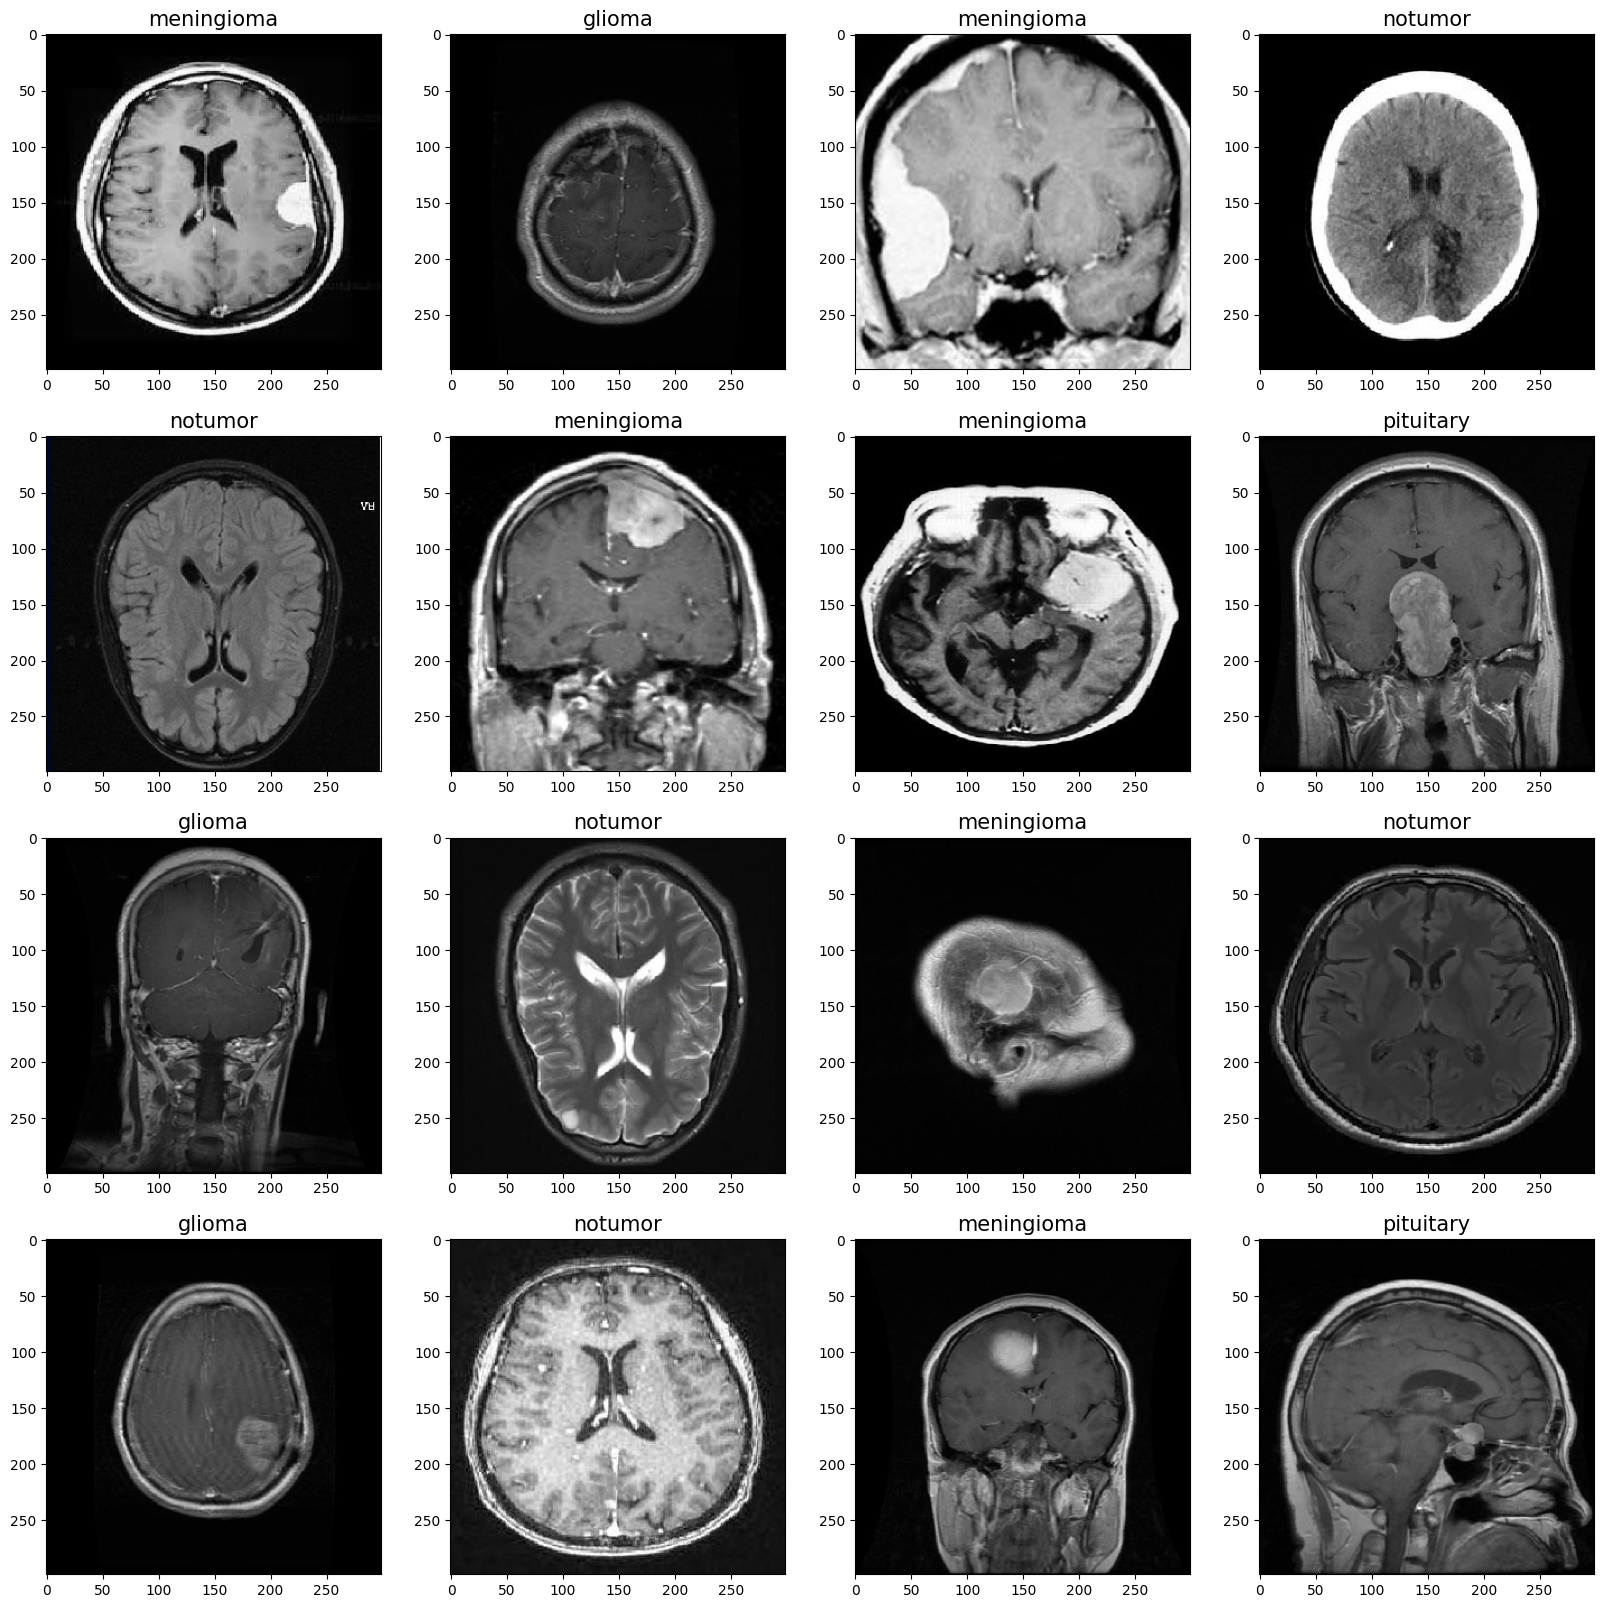

In [11]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Layer

class SEBlock(Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.squeeze = GlobalAveragePooling2D()
        self.excitation = Sequential([
            Dense(channels // self.ratio, activation='relu'),
            Dense(channels, activation='sigmoid')
        ])

    def call(self, inputs):
        x = self.squeeze(inputs)
        x = tf.expand_dims(x, axis=1)
        x = tf.expand_dims(x, axis=1)
        x = self.excitation(x)
        return inputs * x

def CNN_with_SE():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)),
        MaxPooling2D((2, 2)),
        SEBlock(),  
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        SEBlock(),  
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        SEBlock(), 
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')
    ])

    return model

model = CNN_with_SE()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block (SEBlock)              │ (None, 148, 148, 32)   │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_1 (SEBlock)            │ (None, 73, 73, 64)     │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_2 (SEBlock)            │ (None, 35, 35, 128)    │         2,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,167,218 (76.93 MB)

 Trainable params: 20,167,218 (76.93 MB)

 Non-trainable params: 0 (0.00 B)

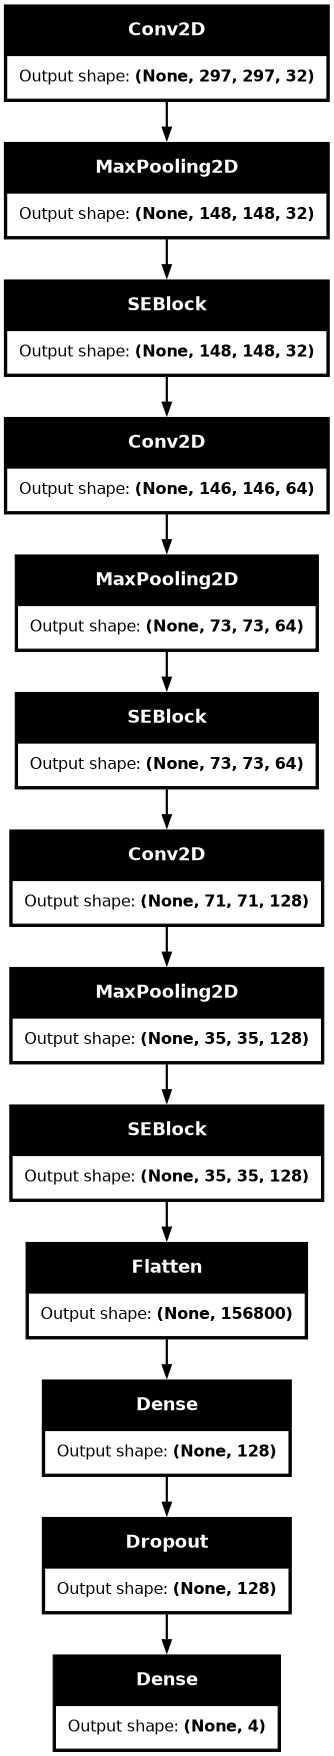

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=80)

In [14]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle=False,
                 callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs'),
                            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
                            tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)])

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 672s 4s/step - accuracy: 0.5832 - loss: 0.9329 - precision: 0.6932 - recall: 0.4162 - val_accuracy: 0.7328 - val_loss: 0.5922 - val_precision: 0.7870 - val_recall: 0.6824
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - accuracy: 0.8431 - loss: 0.4087 - precision: 0.8618 - recall: 0.8189 - val_accuracy: 0.8595 - val_loss: 0.3535 - val_precision: 0.8695 - val_recall: 0.8443
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 686s 4s/step - accuracy: 0.9008 - loss: 0.2661 - precision: 0.9110 - recall: 0.8915 - val_accuracy: 0.9069 - val_loss: 0.2503 - val_precision: 0.9105 - val_recall: 0.9008
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 687s 4s/step - accuracy: 0.9458 - loss: 0.1649 - precision: 0.9476 - recall: 0.9434 - val_accuracy: 0.9267 - val_loss: 0.1841 - val_precision: 0.9265 - val_recall: 0.9237
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - accuracy: 0.9597 - loss: 0.1160 - precision: 0.9617 - recall: 0.9590 - val_accuracy: 0.9313 - val_los

In [15]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

In [17]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

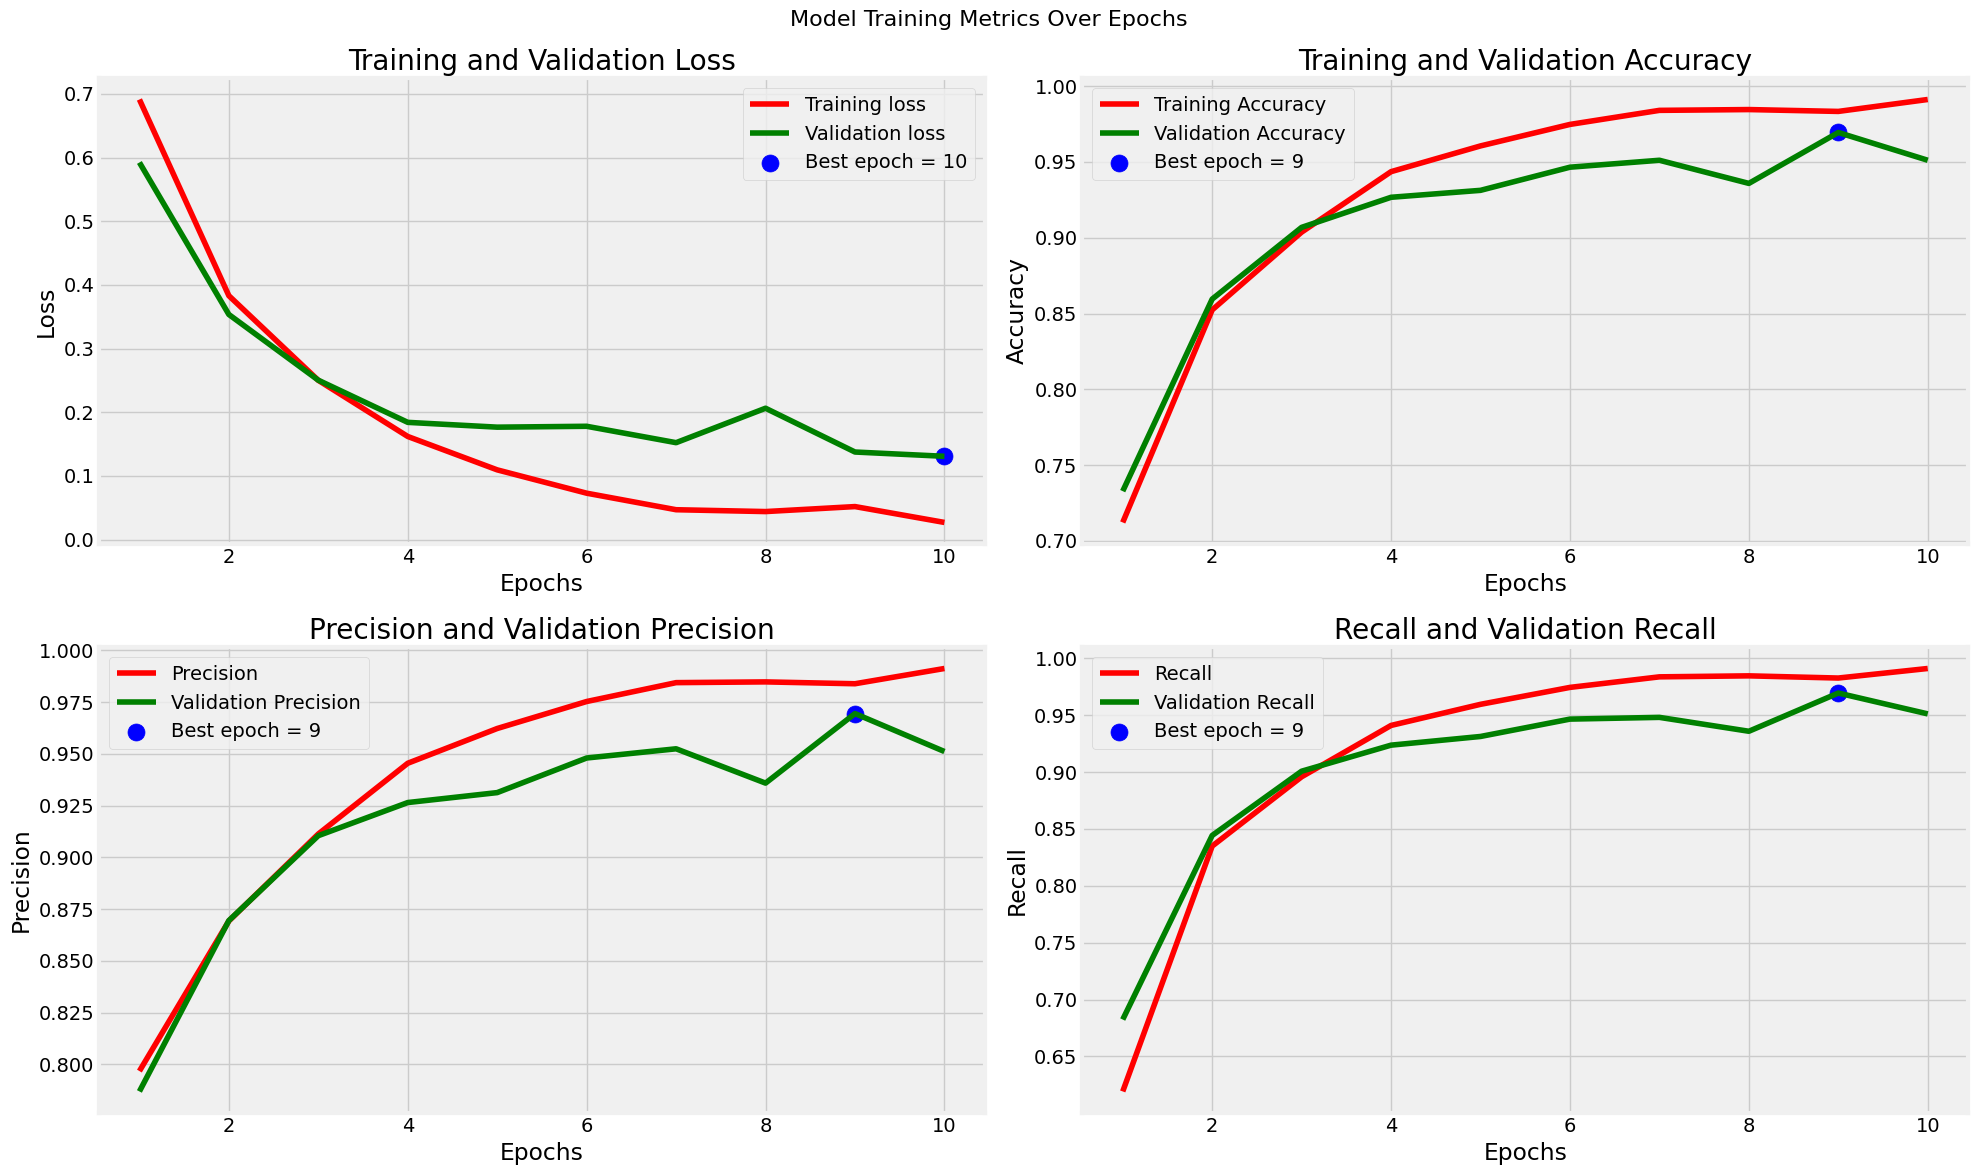

In [18]:
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

In [19]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9932 - loss: 0.0203 - precision: 0.9932 - recall: 0.9932
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9523 - loss: 0.1626 - precision: 0.9523 - recall: 0.9523
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 535ms/step - accuracy: 0.9694 - loss: 0.1498 - precision: 0.9694 - recall: 0.9694
Train Loss: 0.0151
Train Accuracy: 99.58%
--------------------
Validation Loss: 0.1348
Validation Accuracy: 95.57%
--------------------
Test Loss: 0.1600
Test Accuracy: 96.19%


In [20]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 542ms/step


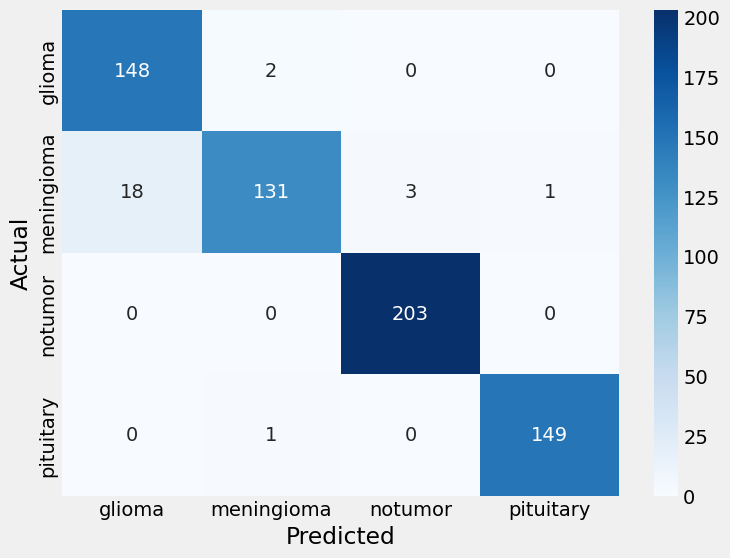

In [21]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       150
           1       0.98      0.86      0.91       153
           2       0.99      1.00      0.99       203
           3       0.99      0.99      0.99       150

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656



In [23]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def predict(img_path, model, actual_class=None):
    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((299, 299))
    img_array = np.array(img) / 255.0  # Normalize pixel values

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    class_probs = model.predict(img_array)

    # Define class labels
    class_labels = ['glioma', 'meningioma', 'no tumor', 'pituitary']

    # Get predicted class label
    predicted_class_index = np.argmax(class_probs)
    predicted_class = class_labels[predicted_class_index]

    # Calculate accuracy
    if actual_class is not None:
        accuracy = class_probs[0][predicted_class_index]
        accuracy_percent = accuracy * 100
        accuracy_message = f'Accuracy: {accuracy_percent:.2f}%'
    else:
        accuracy_message = ''

    # Display the image, actual class, predicted class, and accuracy
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f'Actual Class: {actual_class}\nPredicted Class: {predicted_class}\n{accuracy_message}', fontsize=12)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


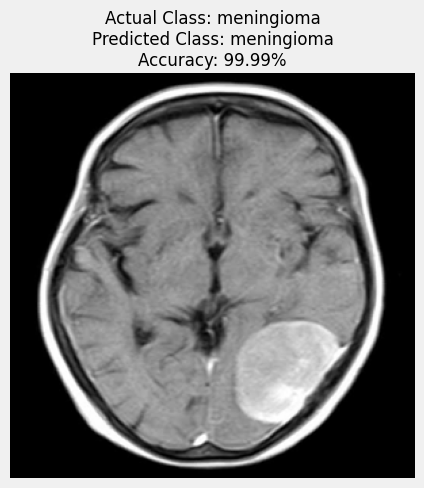

In [24]:
img_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0004.jpg' 
actual_class = 'meningioma'  
predict(img_path, model, actual_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


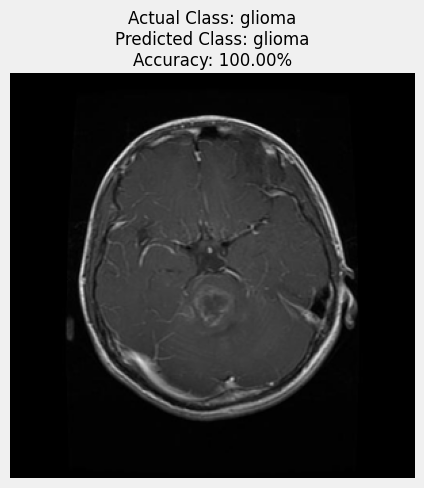

In [25]:
img_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg'  
actual_class = 'glioma'  
predict(img_path, model, actual_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


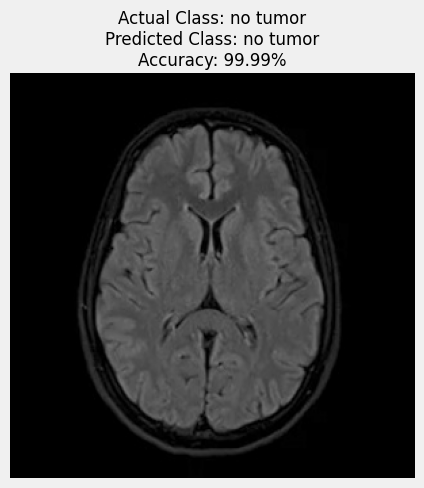

In [29]:
img_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0002.jpg'  
actual_class = 'no tumor'  
predict(img_path, model, actual_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


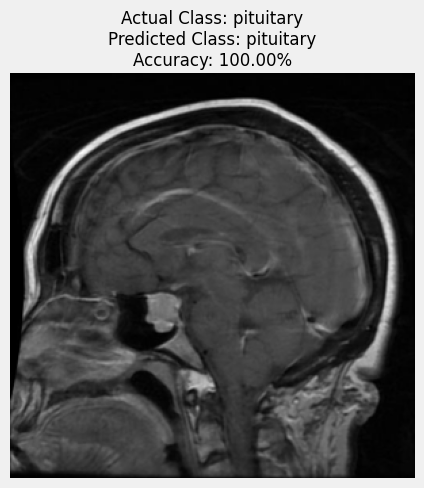

In [28]:
img_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0005.jpg'  
actual_class = 'pituitary'  
predict(img_path, model, actual_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


(-0.5, 511.5, 511.5, -0.5)

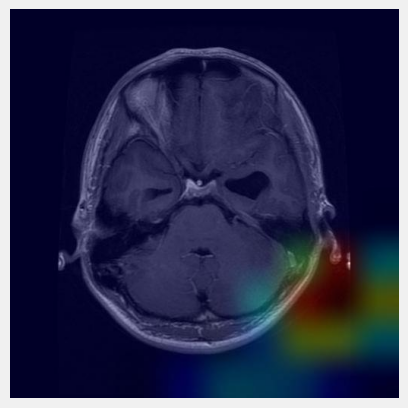

In [82]:
last_conv_layer_name = "block14_sepconv2"

def get_img_array(img_path, size = (299 , 299)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model = model , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if view :
        display(Image(cam_path))
          
def decode_predictions(preds):
    classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction


def make_prediction(img_path, model=model, last_conv_layer_name=last_conv_layer_name, campath="cam.jpeg", view=False):
    img_array = get_img_array(img_path, size=(299, 299))
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap, cam_path=campath, view=view)
    return campath, preds

import matplotlib.pyplot as plt

campath, predictions = make_prediction("/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0004.jpg", campath="123.jpeg", view=False)
test_img = plt.imread(campath)
plt.imshow(test_img)
plt.axis("off")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


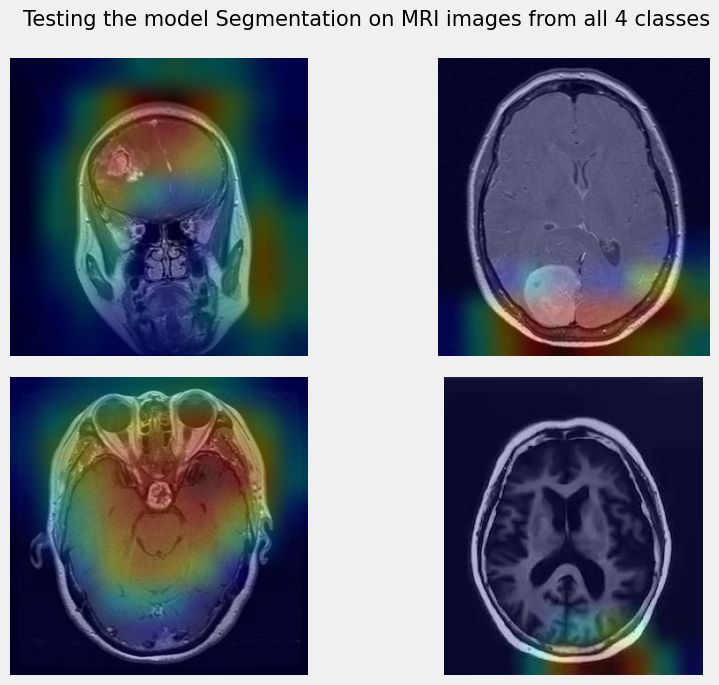

In [106]:
import matplotlib.pyplot as plt

# Path array containing the paths of the images
path_array = [
    '/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0000.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0010.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0021.jpg' ,
    '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0003.jpg'
]

# Create a figure to display the images
fig = plt.figure(figsize=(10, 7)) 
fig.suptitle("Testing the model Segmentation on MRI images from all 4 classes", fontsize=15)

# Iterate over all 8 images in the path array
for i, img_path in enumerate(path_array):
    ax = plt.subplot(2, 2, i + 1)  
    
    # Make prediction for the current image
    campath, prediction = make_prediction(img_path, campath="123.jpeg", view=False)
    
    # Load and display the image
    test_img = plt.imread(campath)
    ax.imshow(test_img)
    ax.axis("off")

plt.tight_layout()
